# Practical: MACE
In this practical, you'll explore how to train and evaluate a MACE model. We will use EMT potential for demonstration, practically, you can use DFT or other potentials as well.


## Data Generation
First, we need to generate the training data. We will use EMT potential running on the ASAP3 package for the Copper system as an example. Then use MACE to train a model on this system. Finally, we will compare our results with the target potential.

Our data will be generated through molecular dynamics with NPT ensemble, at 800 K, and save 40 structures.

In [160]:
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution,Stationary
from ase.md.nvtberendsen import NVTBerendsen
from ase.md.verlet import VelocityVerlet
from ase.md.npt import NPT
from ase.md import MDLogger
from ase import units
from ase.io import write
import os
from time import perf_counter
from ase.calculators.singlepoint import SinglePointCalculator

def run_md(atoms, calculator, ensemble, time_step, temperature, num_md_steps, num_interval, output_filename):
    # Set calculator (EMT in this case)
    atoms.calc = calculator

    # Set the momenta corresponding to the given "temperature"
    MaxwellBoltzmannDistribution(atoms, temperature_K=temperature,force_temp=True)
    Stationary(atoms)  # Set zero total momentum to avoid drifting

    # Set output filenames
    log_filename = output_filename + ".log"
    print("log_filename = ",log_filename)
    traj_filename = output_filename + ".traj"
    print("traj_filename = ",traj_filename)

    xyz_file = output_filename + ".xyz"
    print("xyz_filename = ",xyz_file)

    # Remove old files if they exist
    if os.path.exists(log_filename): os.remove(log_filename)
    if os.path.exists(traj_filename): os.remove(traj_filename)
    if os.path.exists(xyz_file): os.remove(xyz_file)  
    # Define the MD dynamics class object
    if ensemble == 'nve':
        dyn = VelocityVerlet(atoms,
                             time_step * units.fs,
                             trajectory = traj_filename,
                             loginterval=num_interval
                            )
    elif ensemble == 'nvt':
        dyn = NVTBerendsen(atoms,
                           time_step * units.fs,
                           temperature_K=temperature,
                           taut=100.0 * units.fs,
                           trajectory = traj_filename,
                           loginterval=num_interval
                          )
    elif ensemble == 'npt':
        sigma   = 1.0     # External pressure in bar
        ttime   = 20.0    # Time constant in fs
        pfactor = 2e6     # Barostat parameter in GPa
        dyn = NPT(atoms,
          time_step*units.fs,
          temperature_K = temperature,
          externalstress = sigma*units.bar,
          ttime = ttime*units.fs,
          pfactor = pfactor*units.GPa*(units.fs**2),
          logfile = log_filename,
          trajectory = traj_filename,
          loginterval=num_interval
          )
    else:
        raise ValueError("Invalid ensemble, must be nve, nvt, or npt")
    
    # Print statements
    def print_dyn():
        imd = dyn.get_number_of_steps()
        etot  = atoms.get_total_energy()
        temp_K = atoms.get_temperature()
        stress = atoms.get_stress(include_ideal_gas=True)/units.GPa
        stress_ave = (stress[0]+stress[1]+stress[2])/3.0
        elapsed_time = perf_counter() - start_time
        print(f"  {imd: >3}   {etot:.3f}    {temp_K:.2f}    {stress_ave:.2f}  {stress[0]:.2f}  {stress[1]:.2f}  {stress[2]:.2f}  {stress[3]:.2f}  {stress[4]:.2f}  {stress[5]:.2f}    {elapsed_time:.3f}")


    def save_xyz():
        # Save the current configuration to the trajectory file
        atoms_copy = dyn.atoms.copy()
        atoms_copy.calc = SinglePointCalculator(atoms_copy,
                                                energy=atoms.get_potential_energy(),
                                                forces = atoms.get_forces(),
                                                stress = atoms.get_stress(include_ideal_gas=True))
        # atoms_copy.info['REF_energy']=  atoms.get_potential_energy()
        # atoms_copy.set_array(forces,'REF_forces')
        write(xyz_file, atoms_copy, format='extxyz', append=True)

    dyn.attach(print_dyn, interval=num_interval)
    dyn.attach(save_xyz, interval=num_interval)

    # Set MD logger
    dyn.attach(MDLogger(dyn, atoms, log_filename, header=True, stress=True,peratom=True, mode="w"), interval=num_interval)

    # Now run MD simulation
    print(f"    imd     Etot(eV)    T(K)    stress(mean,xx,yy,zz,yz,xz,xy)(GPa)  elapsed_time(sec)")
    start_time = perf_counter()
    dyn.run(num_md_steps)



In [161]:
from asap3 import EMT
from ase.build import bulk

calculator = EMT()
# Set up a fcc-Cu crystal
atoms = bulk("Cu", "fcc", cubic=True, a=3.615)
atoms.pbc = True
atoms *= 2 # 2x2x2 supercell
print("atoms = ",atoms)

# input parameters
time_step    = 1.0      # MD step size in fsec
temperature  = 800     # Temperature in Kelvin
num_md_steps = 2000   # Total number of MD steps
num_interval = 50     # Print out interval for .log and .traj

output_filename = "./tmp/Cu_fcc_2x2x2"

ensemble = 'npt'

run_md(atoms, calculator, ensemble, time_step, temperature, num_md_steps, num_interval, output_filename)


atoms =  Atoms(symbols='Cu32', pbc=True, cell=[7.23, 7.23, 7.23])
log_filename =  ./tmp/Cu_fcc_2x2x2.log
traj_filename =  ./tmp/Cu_fcc_2x2x2.traj
xyz_filename =  ./tmp/Cu_fcc_2x2x2.xyz
    imd     Etot(eV)    T(K)    stress(mean,xx,yy,zz,yz,xz,xy)(GPa)  elapsed_time(sec)
   50   5.711    595.29    -3.28  -3.14  -3.70  -2.99  -1.09  0.13  0.81    0.013
  100   11.283    824.59    -8.20  -6.04  -10.23  -8.34  0.20  1.45  0.56    0.025
  150   6.508    598.12    2.69  3.53  1.29  3.24  1.38  -0.28  0.09    0.035
  200   6.025    701.64    7.84  7.72  8.11  7.69  0.31  -0.06  0.01    0.045
  250   7.380    759.06    5.98  6.43  5.83  5.69  0.74  -0.42  0.20    0.054
  300   9.632    802.70    -0.08  0.98  -1.64  0.41  0.17  -0.63  0.45    0.063
  350   8.280    816.36    -1.04  -0.42  -0.54  -2.16  -0.96  -1.08  -1.40    0.072
  400   6.089    770.35    -0.30  -0.10  0.81  -1.59  -1.10  -1.54  -1.31    0.081
  450   5.722    704.68    -2.41  -3.46  0.23  -4.00  -1.64  -0.41  -0.63    0.090

## Compute E0
Atomic energies are computed using the EMT potential by putting a single atom in a box. This is essential for the MACE model.

In [162]:
from ase import Atoms

# Create a single Cu atom in a large box (to simulate vacuum conditions)
single_Cu = Atoms('Cu', positions=[[0, 0, 0]], cell=[20, 20, 20], pbc=False)

# Use the already defined calculator (EMT)
single_Cu.calc = calculator

# Compute and print the atomic energy
energy = single_Cu.get_potential_energy()
print("Atomic energy of single Cu atom: {:.4f} eV".format(energy))

Atomic energy of single Cu atom: 3.5100 eV


In [163]:
import pandas as pd

log_filename = output_filename + ".log"
df = pd.read_csv(log_filename, delim_whitespace=True, skiprows=1,
                 names=['Time[ps]','Etot/N[eV]','Epot/N[eV]','Ekin/N[eV]','T[K]','stress(xx)','stress(yy)','stress(zz)','stress(yz)','stress(xz)','stress(xy)'])
df

,Time[ps],Etot/N[eV],Epot/N[eV],Ekin/N[eV],T[K],stress(xx),stress(yy),stress(zz),stress(yz),stress(xz),stress(xy)
0,0.05,0.1785,0.1015,0.0769,595.3,-3.145,-3.696,-2.990,-1.086,0.127,0.808
1,0.10,0.3526,0.2460,0.1066,824.6,-6.036,-10.227,-8.341,0.201,1.451,0.561
2,0.15,0.2034,0.1261,0.0773,598.1,3.529,1.293,3.241,1.380,-0.285,0.092
3,0.20,0.1883,0.0976,0.0907,701.6,7.716,8.105,7.691,0.314,-0.055,0.005
4,0.25,0.2306,0.1325,0.0981,759.1,6.430,5.833,5.691,0.739,-0.419,0.200
5,0.30,0.3010,0.1972,0.1038,802.7,0.982,-1.644,0.412,0.166,-0.628,0.447
6,0.35,0.2587,0.1532,0.1055,816.4,-0.424,-0.541,-2.164,-0.964,-1.077,-1.402
7,0.40,0.1903,0.0907,0.0996,770.4,-0.101,0.805,-1.594,-1.099,-1.537,-1.307
8,0.45,0.1788,0.0877,0.0911,704.7,-3.460,0.229,-4.003,-1.643,-0.405,-0.633
9,0.50,0.2016,0.1068,0.0948,733.4,-4.989,-3.214,-5.164,-0.103,-0.536,-1.620


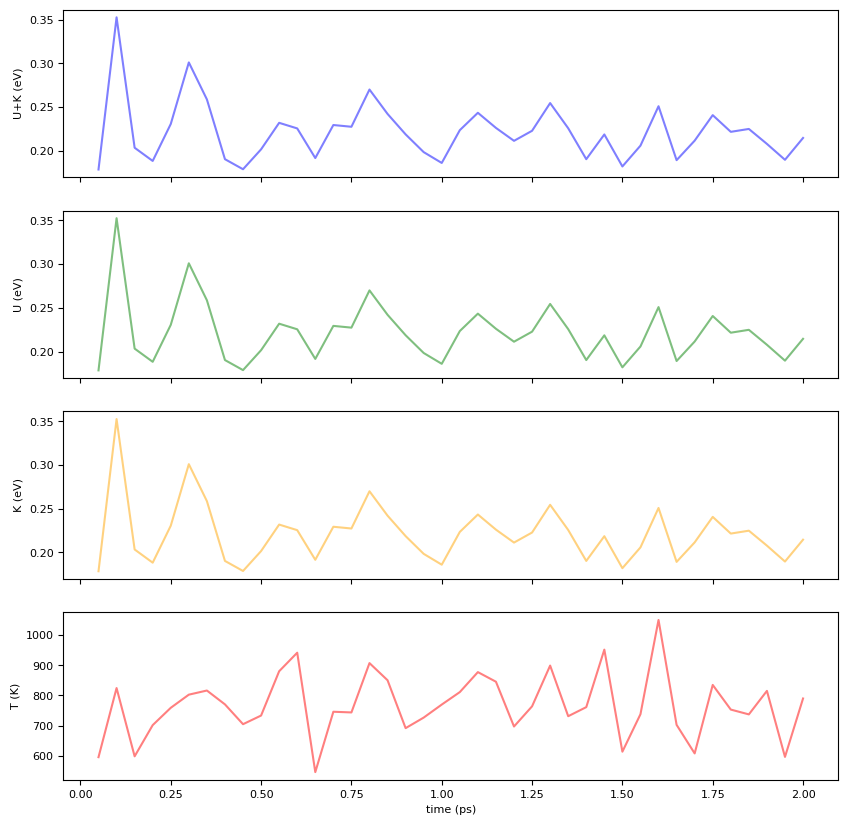

In [164]:
import matplotlib.pyplot as plt


fig = plt.figure(figsize=(10, 10))

#color = 'tab:grey'
ax1 = fig.add_subplot(4, 1, 1)
ax1.set_xticklabels([])
ax1.set_ylabel('U+K (eV)')
ax1.plot(df["Time[ps]"], df["Etot/N[eV]"], color="blue",alpha=0.5)

ax2 = fig.add_subplot(4, 1, 2)
ax2.set_xticklabels([])
ax2.set_ylabel('U (eV)')
ax2.plot(df["Time[ps]"], df["Etot/N[eV]"], color="green",alpha=0.5)

ax3 = fig.add_subplot(4, 1, 3)
ax3.set_xticklabels([])
ax3.set_ylabel('K (eV)')
ax3.plot(df["Time[ps]"], df["Etot/N[eV]"], color="orange",alpha=0.5)

ax4 = fig.add_subplot(4, 1, 4)
ax4.set_xlabel('time (ps)')
ax4.set_ylabel('T (K)')
ax4.plot(df["Time[ps]"], df["T[K]"], color="red",alpha=0.5)

plt.show()


## Data Splitting
We then need to devide the data into training/validation and test sets. The training set is used to train the MACE model, while the test set is used to evaluate its performance. We will use a 90-10 split for this example.

In [165]:
from ase.io import read, write
import random

atoms = read('./tmp/Cu_fcc_2x2x2.xyz', index=":", format='extxyz',parallel=True)
print(f"Number of data: {len(atoms)}")

# Randomly shuffle the data
seed = 123
random.seed(seed)

# determine the index to split an 90% / 10% data
split_idx = int(0.9 * len(atoms))
indices = list(range(len(atoms)))
random.shuffle(indices)

train_atoms = [atoms[i] for i in indices[:split_idx]]
test_atoms = [atoms[i] for i in indices[split_idx:]]

write("tmp/train_valid.xyz", train_atoms, format="extxyz")
write("tmp/test.xyz", test_atoms, format="extxyz")

Number of data: 40


## Training Configuration
You can use the code below to generate training configuration. For more information, please refer to: https://mace-docs.readthedocs.io/en/latest/index.html

In [ ]:
%%writefile ./tmp/training_config.yml

model: "MACE"
num_channels: 32
max_L: 0
r_max: 4.0
name: "mace01"
model_dir: "tmp/MACE_models"
log_dir: "tmp/MACE_models"
checkpoints_dir: "tmp/MACE_models"
results_dir: "tmp/MACE_models"
train_file: "tmp/train_valid.xyz"
valid_fraction: 0.10
test_file: "tmp/test.xyz"
energy_key: "energy"
forces_key: "forces"
stress_key: "stress"
E0s: "{29:3.5100}"
device: cpu
batch_size: 4
max_num_epochs: 50
swa: True
seed: 123


Overwriting ./tmp/training_config.yml


In [167]:
import warnings
warnings.filterwarnings("ignore")
from mace.cli.run_train import main as mace_run_train_main
import sys
import logging

def train_mace(config_file_path):
    logging.getLogger().handlers.clear()
    sys.argv = ["program", "--config", config_file_path]
    mace_run_train_main()


## Training the MACE Model
Now we can start training the MACE model. This process might be time-consuming, depending on the size of your dataset and the complexity of the model. The training process involves optimizing the model parameters to minimize the difference between the predicted and target energies and forces.

In [168]:
train_mace("tmp/training_config.yml")

2025-04-16 03:48:29.777 INFO: ===========VERIFYING SETTINGS===========
2025-04-16 03:48:29.778 INFO: MACE version: 0.3.12
2025-04-16 03:48:29.778 INFO: Using CPU
2025-04-16 03:48:29.849 INFO: ===========LOADING INPUT DATA===========
2025-04-16 03:48:29.850 INFO: Using heads: ['default']
2025-04-16 03:48:29.851 INFO: =============    Processing head default     ===========
2025-04-16 03:48:29.867 WARNING: Since ASE version 3.23.0b1, using energy_key 'energy' is no longer safe when communicating between MACE and ASE. We recommend using a different key, rewriting 'energy' to 'REF_energy'. You need to use --energy_key='REF_energy' to specify the chosen key name.
2025-04-16 03:48:29.870 WARNING: Since ASE version 3.23.0b1, using forces_key 'forces' is no longer safe when communicating between MACE and ASE. We recommend using a different key, rewriting 'forces' to 'REF_forces'. You need to use --forces_key='REF_forces' to specify the chosen key name.
2025-04-16 03:48:29.873 WARNING: Since AS

## Track Training Results
You can then check the training curves in `tmp/MACE_models/mace01_run-123_train_default_stage_one.png` and `tmp/MACE_models/mace01_run-123_train_default_stage_two.png` to see how the training process goes. The first one is the training curve for stage one, and the second one is for stage two. 

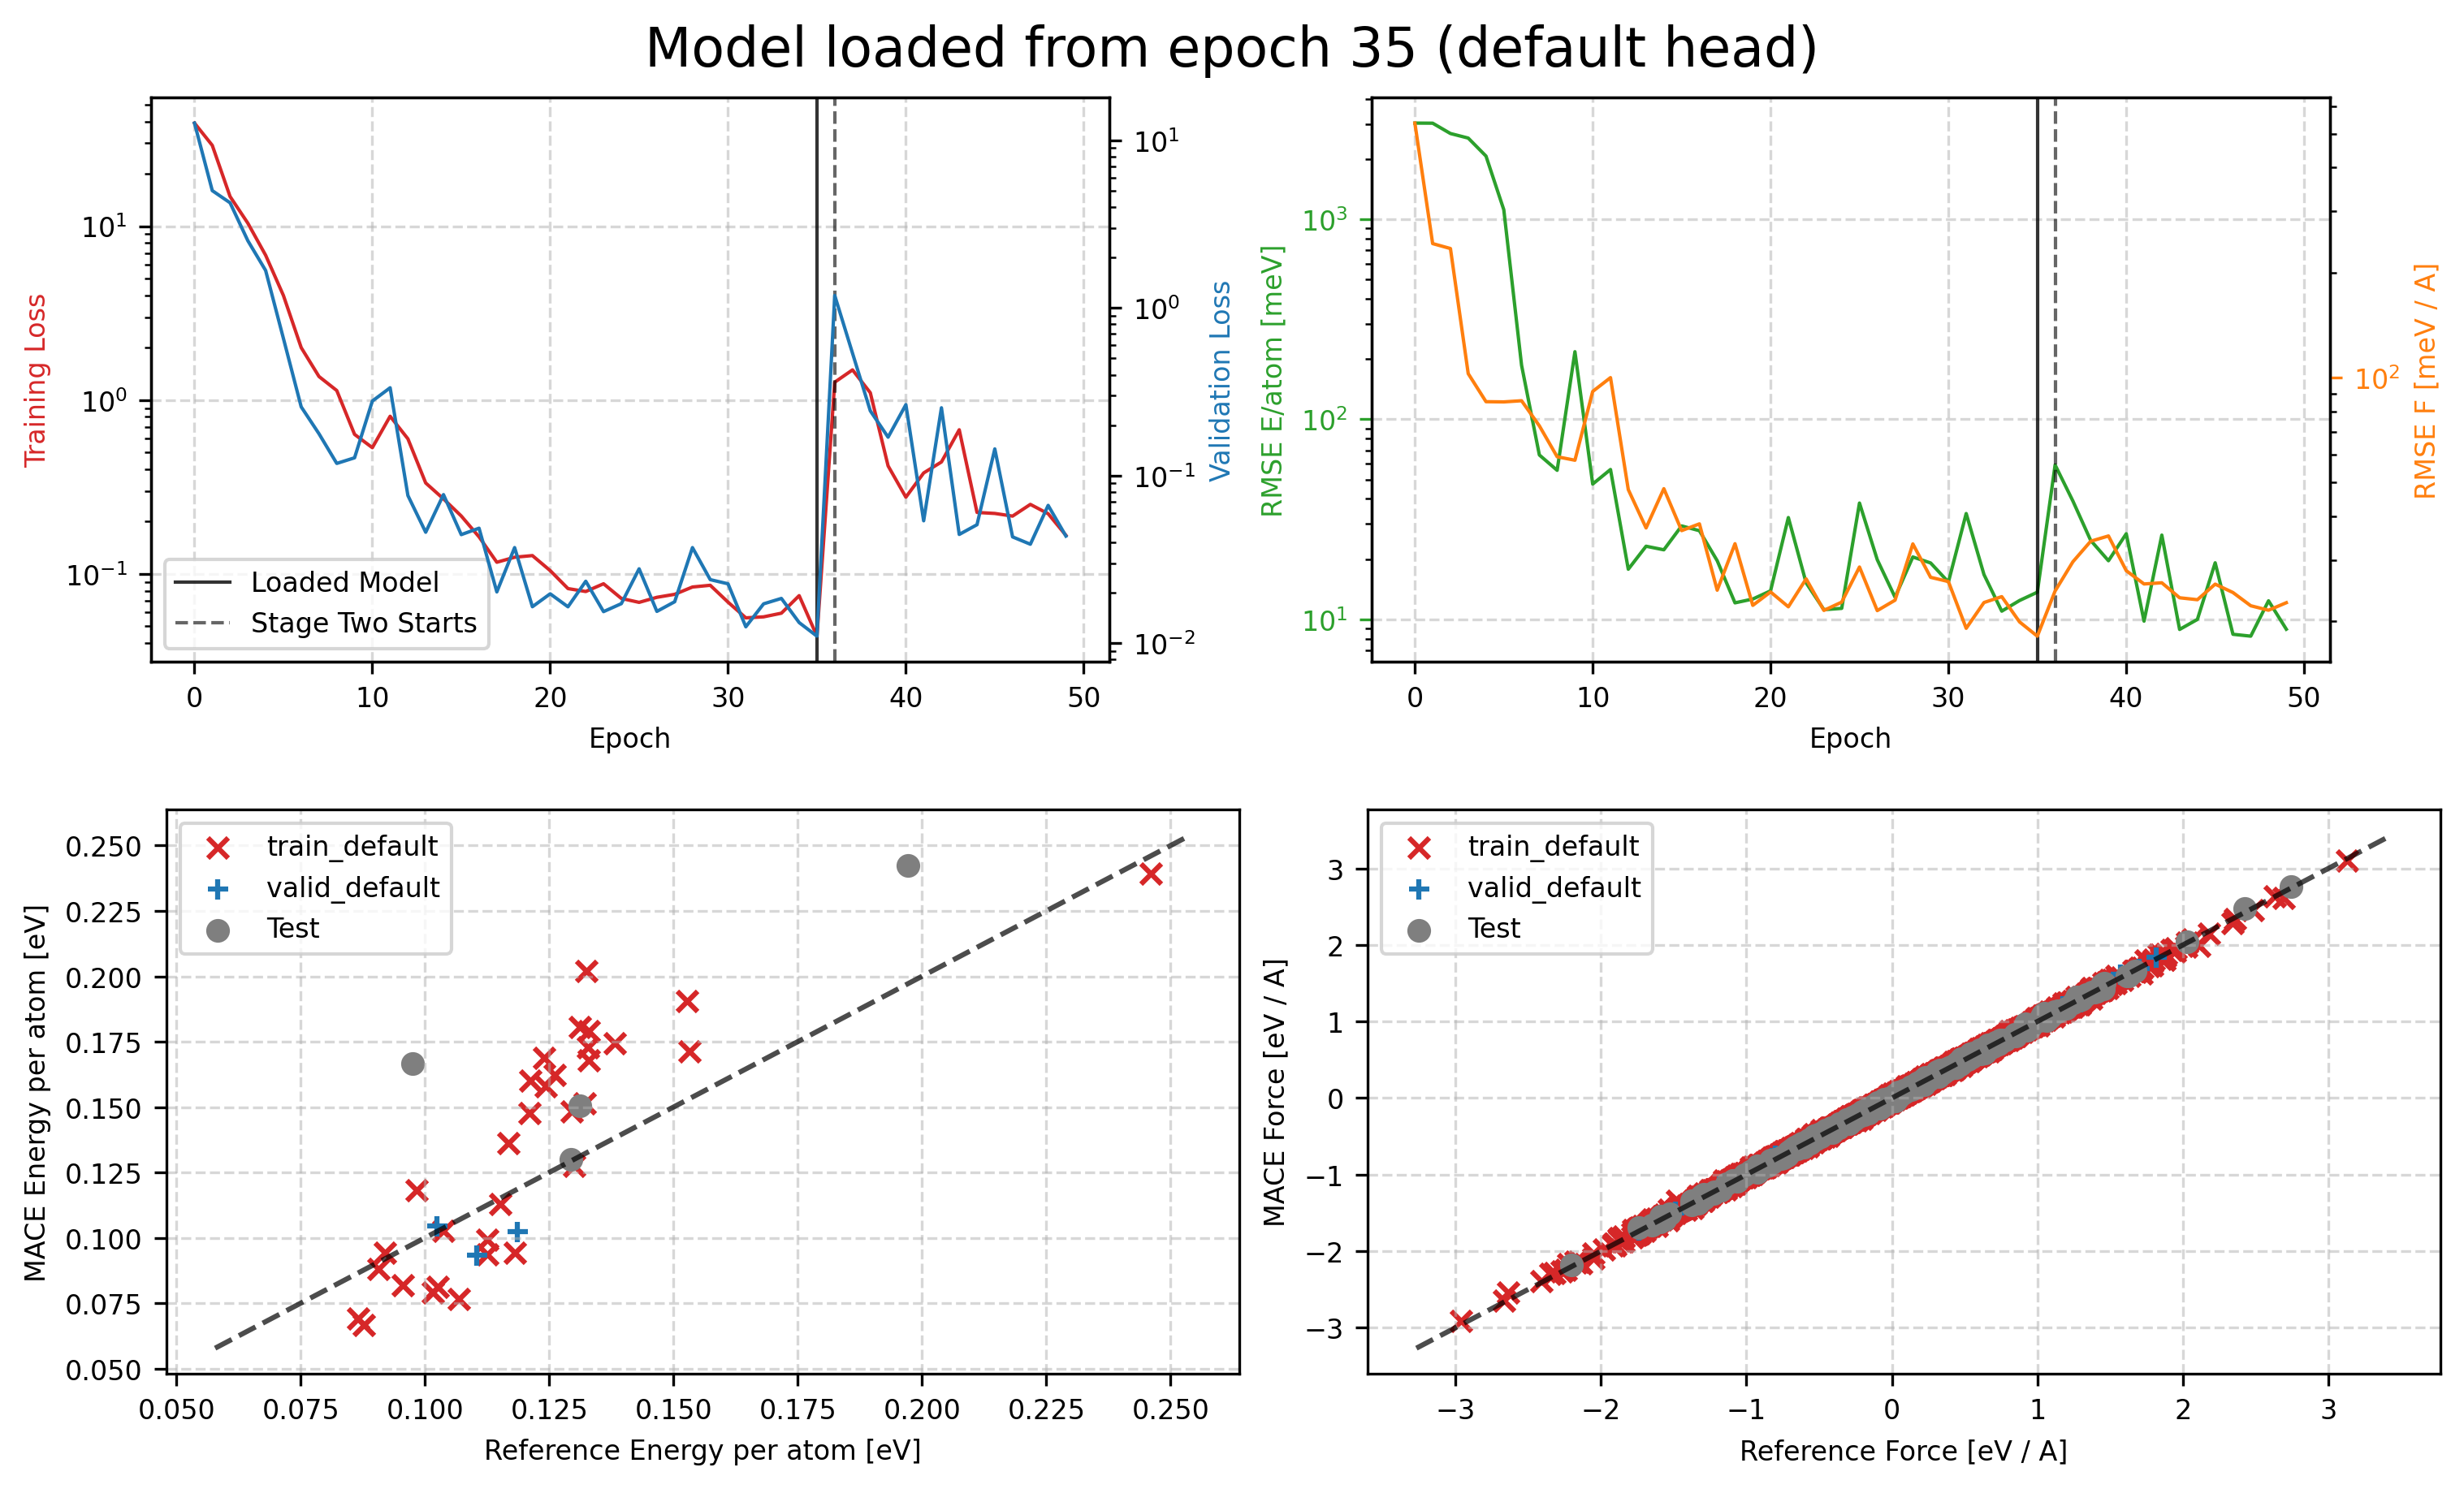

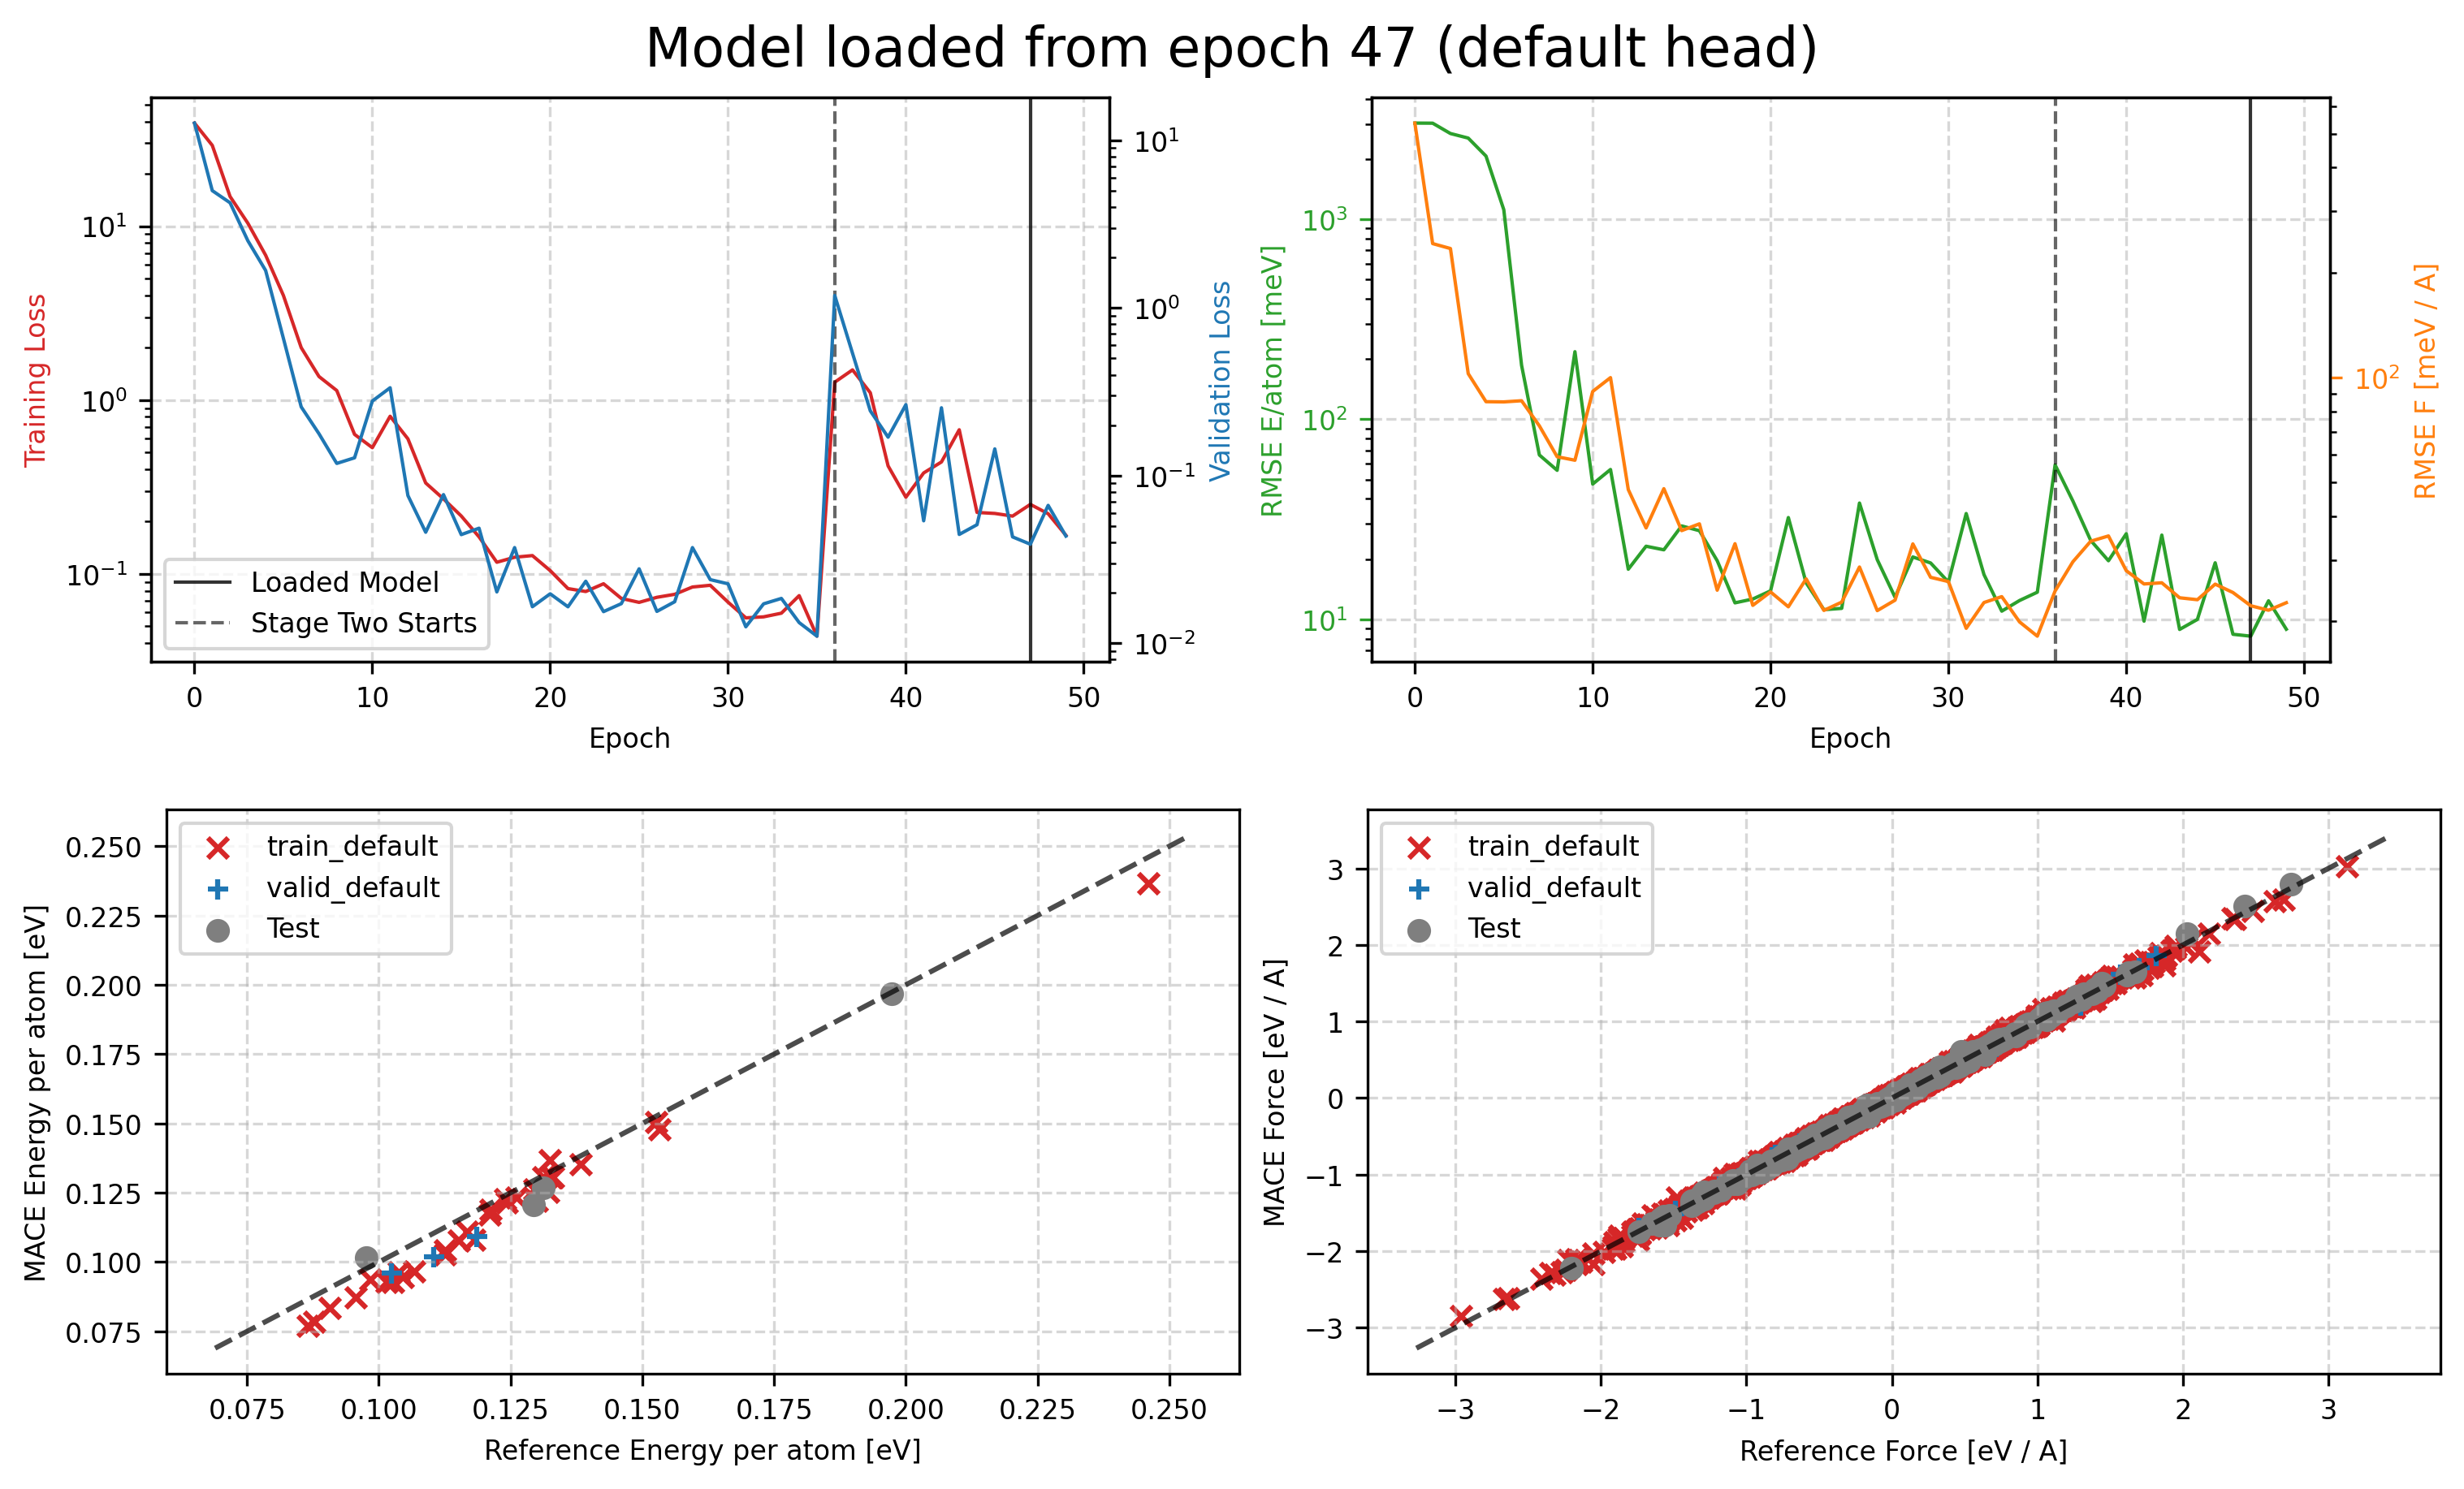

In [173]:
from IPython.display import Image, display

display(Image(filename='tmp/MACE_models/mace01_run-123_train_default_stage_one.png'))
display(Image(filename='tmp/MACE_models/mace01_run-123_train_default_stage_two.png'))


## Further Test: Equation of State
Then we can test the equation of state of the model.



2025-04-16 03:50:10.278 INFO: Using CPU
No dtype selected, switching to float64 to match model dtype.
MACE: v0 = 45.7100, e0 = -0.0468, B = 0.7390
EMT: v0 = 46.3859, e0 = -0.0062, B = 0.8378


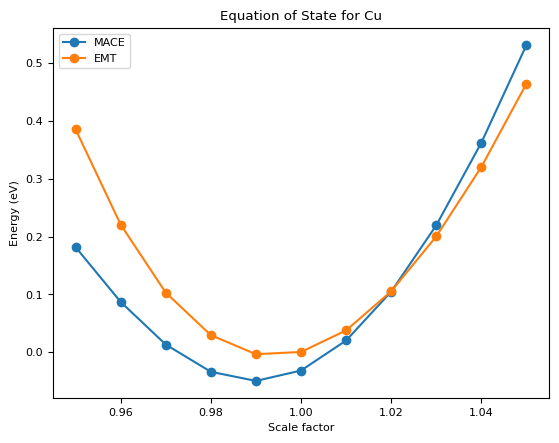

In [172]:
from mace.calculators import MACECalculator
import numpy as np
from ase.eos import EquationOfState
calculator = MACECalculator(
    model_paths="tmp/MACE_models/mace01_run-123_stagetwo.model",
    device="cpu")

import matplotlib.pyplot as plt
# Define a range of scale factors
scale_factors = np.linspace(0.95, 1.05, 11)
energies_mace = []
energies_emt = []
volumes = []
atoms = bulk("Cu", "fcc", cubic=True, a=3.615)
atoms.pbc = True

for s in scale_factors:
    # Make a copy of the original bulk Cu structure
    atoms_scaled = atoms.copy()
    
    # Scale the cell and positions accordingly
    atoms_scaled.set_cell(atoms_scaled.get_cell() * s, scale_atoms=True)

    atoms_scaled_emt = atoms_scaled.copy()
    # Assign the MACE calculator
    atoms_scaled.calc = calculator

    atoms_scaled_emt.calc = EMT()
    volumes.append(atoms_scaled.get_volume())
    # Compute and store the potential energy
    energies_mace.append(atoms_scaled.get_potential_energy())
    energies_emt.append(atoms_scaled_emt.get_potential_energy())

eos_mace = EquationOfState(volumes, energies_mace)
eos_emt = EquationOfState(volumes, energies_emt)

# Fit the EOS to the MACE energies
v0_mace, e0_mace, B_mace = eos_mace.fit()
# Fit the EOS to the EMT energies
v0_emt, e0_emt, B_emt = eos_emt.fit()

print(f"MACE: v0 = {v0_mace:.4f}, e0 = {e0_mace:.4f}, B = {B_mace:.4f}")
print(f"EMT: v0 = {v0_emt:.4f}, e0 = {e0_emt:.4f}, B = {B_emt:.4f}")

# Plot the Equation of State (EOS)
plt.figure()
plt.plot(scale_factors, energies_mace, marker="o", label="MACE")
plt.plot(scale_factors, energies_emt, marker="o", label="EMT")
plt.legend()
plt.xlabel("Scale factor")
plt.ylabel("Energy (eV)")
plt.title("Equation of State for Cu")
plt.show()

```{tip}
How do you think about the results? How to improve the model?
```